In [1]:
import os
import re
import email
import seaborn as sns
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import pandas as pd

In [2]:
# base_dir = r"C:\Users\sherm\Documents\Grad School - Classes\MSDS - 7333 - Quantifying the World\Case Study 3"
base_dir = "D:/Project/Quantifying the World/SpamAssassinMessages"
folders = []

# Read in the data using os.walk to go through multiple directories
for i in os.walk(base_dir):
    if i[0] != base_dir:
        folders.append(i[0])

# os.walk was easier than glob in this case

In [3]:
for folder in folders:
    print(folder) # visualize the folders all the emails live in

D:/Project/Quantifying the World/SpamAssassinMessages\easy_ham
D:/Project/Quantifying the World/SpamAssassinMessages\easy_ham_2
D:/Project/Quantifying the World/SpamAssassinMessages\hard_ham
D:/Project/Quantifying the World/SpamAssassinMessages\spam
D:/Project/Quantifying the World/SpamAssassinMessages\spam_2


In [4]:
def getFiles(folder):
    files = []

    for file in os.listdir(folder):
        files.append(file)
    
    return files

In [5]:
for folder in folders:
    if re.search("spam", folder):
        print(folder)

D:/Project/Quantifying the World/SpamAssassinMessages\spam
D:/Project/Quantifying the World/SpamAssassinMessages\spam_2


In [6]:
mailType = []
textType = []
body = []
target = []

for folder in folders:
    for file in getFiles(folder):
        with open(f"{folder}/{file}", encoding = 'ISO-8859-1') as file_handle: #encoding handles unusual characters
            x = email.message_from_file(file_handle) # getting email object

        if re.search("spam", folder):
            target.append(1)
        else:
            target.append(0)

        mail = x.get_content_type()
        text = x.get_content_charset()

        mailType.append(mail)
        textType.append(text)

        if mail == 'text/plain':
            body.append(x.get_payload()) # getting payload of all text/plain charactertypes

        elif mail == 'text/html':
            tmp = BeautifulSoup(x.get_payload(), 'html.parser') # getting payload of text/html
            tmp = tmp.text.replace('\n', ' ')
            body.append(tmp)
        
        elif x.is_multipart(): # Randy's code to iterate through multipart messages and obtain payload
            combine = []

            for i in x.get_payload():
                mtype = i.get_content_type()
                ttype = i.get_content_charset()

                if mtype == 'text/plain':
                    combine.append(i.get_payload())

                elif mtype == 'text/html':
                    tmp = BeautifulSoup(i.get_payload(), 'html.parser')
                    tmp = tmp.text.replace('\n', ' ')
                    combine.append(tmp)

            body.append([' '.join(str(i)) for i in combine])
        
        else:
            body.append(x.get_payload())

### The above code is credited to Dr. Robert Slater with minor edits

In [7]:
maildf = pd.DataFrame() # creating dataframe of payloads
maildf["Body"] = body
maildf["Mail Type"] = mailType
maildf["Text Type"] = textType
maildf["Target"] = target
maildf

,Body,Mail Type,Text Type,Target
0,"Date: Wed, 21 Aug 2002 10:54:46 -05...",text/plain,us-ascii,0
1,"Martin A posted:\nTassos Papadopoulos, the Gre...",text/plain,us-ascii,0
2,Man Threatens Explosion In Moscow \n\nThursday...,text/plain,us-ascii,0
3,Klez: The Virus That Won't Die\n \nAlready the...,text/plain,us-ascii,0
4,"> in adding cream to spaghetti carbonara, whi...",text/plain,us-ascii,0
...,...,...,...,...
9348,[ \t P r e f e r r e d N o n - S m o k e ...,multipart/alternative,None,1
9349,"Dear Subscriber,\n\nIf I could show you a way ...",text/plain,iso-8859-1,1
9350,****Mid-Summer Customer Appreciation SALE!****...,text/plain,windows-1252,1
9351,ATTN:SIR/MADAN \n\n ...,text/plain,iso-8859-1,1


In [8]:
for i in range(len(maildf)):
    if type(maildf.iloc[i,0]) == list:
        maildf.iloc[i,0] = ''.join(maildf.iloc[i,0])

In [9]:
maildf

,Body,Mail Type,Text Type,Target
0,"Date: Wed, 21 Aug 2002 10:54:46 -05...",text/plain,us-ascii,0
1,"Martin A posted:\nTassos Papadopoulos, the Gre...",text/plain,us-ascii,0
2,Man Threatens Explosion In Moscow \n\nThursday...,text/plain,us-ascii,0
3,Klez: The Virus That Won't Die\n \nAlready the...,text/plain,us-ascii,0
4,"> in adding cream to spaghetti carbonara, whi...",text/plain,us-ascii,0
...,...,...,...,...
9348,\t P r e f e r r e d N o n - S m o k e r...,multipart/alternative,None,1
9349,"Dear Subscriber,\n\nIf I could show you a way ...",text/plain,iso-8859-1,1
9350,****Mid-Summer Customer Appreciation SALE!****...,text/plain,windows-1252,1
9351,ATTN:SIR/MADAN \n\n ...,text/plain,iso-8859-1,1


d:\Project\Machine Learning\machinelearning\lib\site-packages\seaborn\axisgrid.py:156: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  figlegend = self._figure.legend(handles, labels, **kwargs)


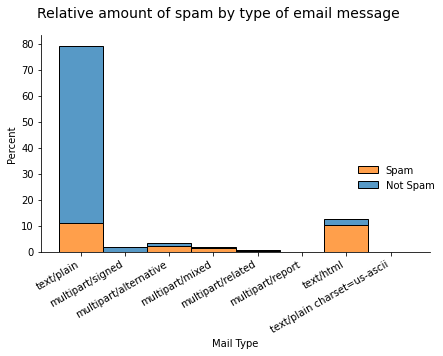

In [10]:
# visualization of distribution of spam payloads by mail type
g = sns.displot(maildf, x='Mail Type', hue='Target', multiple='stack',stat='percent', legend=False) 
g.fig.suptitle('Relative amount of spam by type of email message', fontsize=14)
g.set_xticklabels(rotation=30, horizontalalignment='right')
g.add_legend(title='', labels=['Spam', 'Not Spam'])
plt.tight_layout()

In [11]:
from collections import Counter
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer

In [12]:
import re
word_counts = Counter()

mail_data_df = maildf.copy()

for i in range(maildf['Body'].shape[0]):
    tmp = maildf.iloc[i,0].lower() # casting messages to lowercase
    tmp = tmp.replace('\r',' ').replace('\n',' ').replace('\t',' ').replace('<br>',' ') #removing string newlines, tabs, breaks
    tmp = tmp.split(" ") # splitting string sentences into a list of "words"
    for token in tmp:
        if r'\n' in token:
            token.replace(r'\n',' ') # catching string literal newline
        if '\t' in token:
            token.replace(r'\t',' ') # catching string literal tab
        # count vectorized words    
        word_counts[token.strip()] += 1
    # re-creating a dataframe for with text stripped of special characters
    mail_data_df.iloc[i,0] = ' '.join([word for word in tmp])

extra = Counter({"<pad>":10000001,"<unk>":1000000})
word_counts = word_counts + extra

In [13]:
mail_data_df

,Body,Mail Type,Text Type,Target
0,"date: wed, 21 aug 2002 10:54:46 -05...",text/plain,us-ascii,0
1,"martin a posted: tassos papadopoulos, the gree...",text/plain,us-ascii,0
2,man threatens explosion in moscow thursday a...,text/plain,us-ascii,0
3,klez: the virus that won't die already the m...,text/plain,us-ascii,0
4,"> in adding cream to spaghetti carbonara, whi...",text/plain,us-ascii,0
...,...,...,...,...
9348,p r e f e r r e d n o n - s m o k e r ...,multipart/alternative,None,1
9349,"dear subscriber, if i could show you a way to...",text/plain,iso-8859-1,1
9350,****mid-summer customer appreciation sale!****...,text/plain,windows-1252,1
9351,attn:sir/madan st...,text/plain,iso-8859-1,1


In [14]:
print(len(word_counts))
word_counts.most_common(40000)

139971


[('<pad>', 10000001),
 ('', 1770906),
 ('<unk>', 1000000),
 ('e', 162054),
 ('a', 160972),
 ('i', 145079),
 ('t', 123807),
 ('o', 112416),
 ('s', 103558),
 ('n', 101705),
 ('the', 96036),
 ('r', 93114),
 ('c', 74739),
 ('l', 70655),
 ('d', 64412),
 ('to', 62586),
 ('>', 58883),
 ('h', 58876),
 ('m', 54456),
 ('g', 53142),
 ('u', 51495),
 ('=', 49277),
 ('and', 48230),
 ('of', 47444),
 ('b', 45844),
 ('p', 45730),
 ('0', 44305),
 ('w', 43982),
 ('-', 40585),
 ('y', 39727),
 ('f', 35297),
 ('in', 30540),
 ('.', 26525),
 ('is', 26503),
 ('v', 26436),
 ('for', 25335),
 ('you', 24317),
 ('9', 23346),
 ('2', 22970),
 ('that', 21373),
 ('k', 17784),
 ('this', 17178),
 ('on', 17023),
 ('z', 16856),
 ('it', 16322),
 ('/', 14495),
 ('with', 14349),
 ('your', 14301),
 ('x', 13640),
 ('1', 13482),
 ('j', 12895),
 ('be', 12624),
 (',', 12512),
 ('are', 12056),
 ('have', 11285),
 ('as', 11066),
 ('or', 11016),
 (':', 10627),
 ('from', 10307),
 ('3', 10214),
 ('not', 10061),
 ('5', 9409),
 ('at', 889

In [15]:
for word in list(word_counts): # remove single letter words
    if len(word) < 2:
        del word_counts[word]

In [16]:
print(len(word_counts))
word_counts.most_common(13000) # this represents about 10% of the data

139853


[('<pad>', 10000001),
 ('<unk>', 1000000),
 ('the', 96036),
 ('to', 62586),
 ('and', 48230),
 ('of', 47444),
 ('in', 30540),
 ('is', 26503),
 ('for', 25335),
 ('you', 24317),
 ('that', 21373),
 ('this', 17178),
 ('on', 17023),
 ('it', 16322),
 ('with', 14349),
 ('your', 14301),
 ('be', 12624),
 ('are', 12056),
 ('have', 11285),
 ('as', 11066),
 ('or', 11016),
 ('from', 10307),
 ('not', 10061),
 ('at', 8893),
 ('if', 8683),
 ('by', 8359),
 ('will', 8015),
 ('an', 7491),
 ('but', 7462),
 ('can', 7390),
 ('we', 7308),
 ('all', 7158),
 ('was', 6608),
 ('my', 6397),
 ('mv', 6055),
 ('our', 5977),
 ('has', 5589),
 ('they', 5487),
 ('more', 5336),
 ('get', 5242),
 ('one', 5087),
 ('--', 5028),
 ('do', 4965),
 ('just', 4948),
 ('about', 4801),
 ('so', 4750),
 ('email', 4623),
 ('list', 4601),
 ('out', 4590),
 ('no', 4589),
 ('new', 4429),
 ('what', 4247),
 ('any', 4060),
 ('their', 4043),
 ('which', 3992),
 ('would', 3957),
 ('up', 3909),
 ('like', 3748),
 ('only', 3721),
 ('there', 3595),
 ('

### KNN

In [21]:
from sklearn.neighbors import KNeighborsClassifier

In [17]:
x_data = mail_data_df[['Body','Mail Type', 'Text Type']].copy()
y_data = mail_data_df[['Target']].copy() # where 0 is not spam and 1 is spam

In [18]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, stratify=y_data, test_size=0.20, random_state=42)

In [19]:
c_vector = CountVectorizer()
x_fit = c_vector.fit_transform(x_train['Body'])

In [22]:
knn = KNeighborsClassifier()
knn.fit(x_fit.toarray(), y_train)

d:\Project\Machine Learning\machinelearning\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier()

In [23]:
x_new = c_vector.transform(x_test['Body'])
y_preds = knn.predict(x_new.toarray())

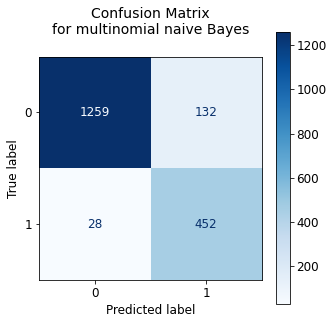

In [24]:
cm = confusion_matrix(y_test['Target'], y_preds)

font = {'size'   : 12}
plt.rc('font', **font)

c_disp = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots(figsize=(5,5))
plt.title('Confusion Matrix\nfor multinomial naive Bayes\n', fontsize=14)
c_disp.plot(cmap=plt.cm.Blues, ax=ax)

In [25]:
from sklearn.metrics import classification_report
print(classification_report(y_test['Target'], y_preds))

              precision    recall  f1-score   support

           0       0.98      0.91      0.94      1391
           1       0.77      0.94      0.85       480

    accuracy                           0.91      1871
   macro avg       0.88      0.92      0.89      1871
weighted avg       0.93      0.91      0.92      1871



### Random Forest

In [30]:
from sklearn.ensemble import RandomForestClassifier

In [31]:
x_data = mail_data_df[['Body','Mail Type', 'Text Type']].copy()
y_data = mail_data_df[['Target']].copy() # where 0 is not spam and 1 is spam
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, stratify=y_data, test_size=0.20, random_state=42)

In [32]:
c_vector = CountVectorizer()
x_fit = c_vector.fit_transform(x_train['Body'])

In [33]:
rf = RandomForestClassifier()
rf.fit(x_fit.toarray(), y_train)

C:\Users\RANDYK~1\AppData\Local\Temp/ipykernel_3556/3877611093.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(x_fit.toarray(), y_train)


RandomForestClassifier()

In [34]:
x_new = c_vector.transform(x_test['Body'])
y_preds = knn.predict(x_new.toarray())

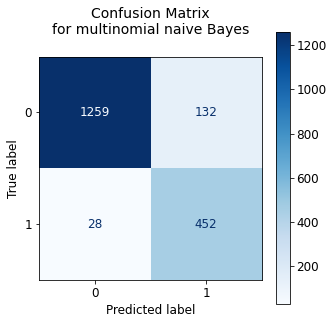

In [35]:
cm = confusion_matrix(y_test['Target'], y_preds)

font = {'size'   : 12}
plt.rc('font', **font)

c_disp = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots(figsize=(5,5))
plt.title('Confusion Matrix\nfor multinomial naive Bayes\n', fontsize=14)
c_disp.plot(cmap=plt.cm.Blues, ax=ax)

In [36]:
print(classification_report(y_test['Target'], y_preds))

              precision    recall  f1-score   support

           0       0.98      0.91      0.94      1391
           1       0.77      0.94      0.85       480

    accuracy                           0.91      1871
   macro avg       0.88      0.92      0.89      1871
weighted avg       0.93      0.91      0.92      1871



#### Train/Test split for OOB Model Evaluation

In [18]:
x_data = mail_data_df[['Body','Mail Type', 'Text Type']].copy()
y_data = mail_data_df[['Target']].copy() # where 0 is not spam and 1 is spam

In [19]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, stratify=y_data, test_size=0.20, random_state=42)

In [20]:
c_vector = CountVectorizer()
x_fit = c_vector.fit_transform(x_train['Body'])

In [21]:
nb = MultinomialNB()
nb.fit(x_fit.toarray(), y_train)

C:\Users\sherm\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


MultinomialNB()

In [22]:
x_new = c_vector.transform(x_test['Body'])
y_preds = nb.predict(x_new.toarray())

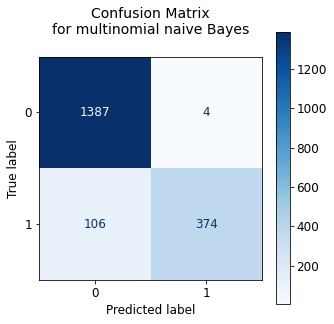

In [23]:
cm = confusion_matrix(y_test['Target'], y_preds)

font = {'size'   : 12}
plt.rc('font', **font)

c_disp = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots(figsize=(5,5))
plt.title('Confusion Matrix\nfor multinomial naive Bayes\n', fontsize=14)
c_disp.plot(cmap=plt.cm.Blues, ax=ax)

In [24]:
print(classification_report(y_test['Target'], y_preds))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96      1391
           1       0.99      0.78      0.87       480

    accuracy                           0.94      1871
   macro avg       0.96      0.89      0.92      1871
weighted avg       0.94      0.94      0.94      1871

